# Recommendation Systems | Project

**Problem Statement -**

Build your own recommendation system for products on an e-commerce website like Amazon.com.

Dataset Link -

https://drive.google.com/file/d/1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW/view?usp=sharing

**Dataset columns** - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

**Source** - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has several datasets. For this case study, we are using the Electronics dataset.

Please do the analysis based on steps( 1 to 8) as given below -

**Steps** -
1. Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics)
2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )
3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
4. Build Popularity Recommender model.
5. Build Collaborative Filtering model.
6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.
7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
8. Summarise your insights.

Please Note -

● If you are facing any memory issue while working on this project, create a small subset (Let’s say 10% of data) and work on it.

● If you are stuck at the model evaluation part of this project.

Please refer to below links -
1. https://surprise.readthedocs.io/en/stable/accuracy.html
2. http://surpriselib.com/ - Getting started, example

# 1. Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics)

In [1]:
#Importing common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Read the dataset
df = pd.read_csv('ratings_Electronics.csv', header=None)

#Checking top 5 records to check if dataset is loaded properly
df.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
#Adding columns to the Dataset
df.columns = ['userId', 'productId', 'ratings', 'timestamp']

#Dropping timestamp column as it is not needed for our Analysis
df.drop('timestamp', axis=1, inplace=True)

#Checking the dataset
df.head()

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


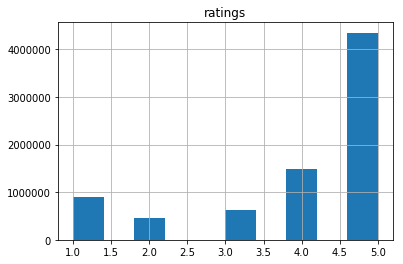

In [4]:
#Plotting histograms
df.hist()
plt.show()

In [5]:
#Checking dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [6]:
#userId & productId are object type as expected. But, ratings are float instead of int
#So, let's check unique values in ratings column to see why the ratings column is float
df['ratings'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: ratings, dtype: int64

In [7]:
#As we can see, ratings column has ratings 1, 2, 3, 4 & 5 only but they are stored as float which is OK for us.
#Let's check if we have any missing values
df.count()

userId       7824482
productId    7824482
ratings      7824482
dtype: int64

# Summary:
We loaded the User ratings for Electronics products which has ratings for almost 8 Lakh which is good large dataset for our Analysis. We dropped timestamp column as we do not need it for our Analysis.

From the Histogram & value_counts, we can see that more than 50% people rate the products as 5 with decreasing trend for lower ratings with an exception for rating 1 which few unhappy Customers would have given.

We don't have any missing values & the dataset is good to proceed further.

# 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

In [8]:
#Creating new DataFrame consisting of userID & if they have rated at least 50 Electronics products or not
ratings_50 = pd.DataFrame(df.groupby(by='userId')['ratings'].count() >= 50)

#Extract only userID who have rated at least 100 books
ratings_50 = pd.DataFrame(ratings_50[ratings_50['ratings'] == True].index)

#Finding records in this new Dataset that are there in ratings dataset
df_subset = df[df['userId'].isin(ratings_50['userId'])].dropna()

#delete temporary Dataset created
del ratings_50

#Checking new dataset
df_subset.head()

,userId,productId,ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [9]:
#Checking size of new Dataset
df_subset.shape

(125871, 3)

# Summary:
We have created a subset of original dataset to make it less sparser by keeping only Users who have rated at least 50 Electronics Products.

By doing this, we have created dataset consisting of only 1.6% data of original data

# 3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

In [10]:
#Importing train_test_split submodule from model_selection module in sklearn library
from sklearn.model_selection import train_test_split

#Splitting the data into 70:30 ratio for training & testing
df_train, df_test = train_test_split(df_subset, test_size=0.30, random_state=5)

# Summary:
We split the Dataset into Training & Testing Datasets randomly in the ratio 70:30

# 4. Build Popularity Recommender model.

In [11]:
#Grouping by productId & counting records then sort in descending order
recommend_train = pd.DataFrame(df_train.groupby(by='productId').count()['userId']).sort_values(by = 'userId', ascending=False)

#Rename column to count
recommend_train.columns = ['count']

#Reset index to get productId as column
recommend_train.reset_index(inplace=True)

#Add new column rank & rank it by descending order of count
recommend_train['rank'] = recommend_train['count'].rank(ascending=False)

In [12]:
#Printing Top 10 popular Electronics Products
recommend_train.head(10)

,productId,count,rank
0,B0088CJT4U,141,1.0
1,B003ES5ZUU,130,2.0
2,B000N99BBC,118,3.0
3,B007WTAJTO,117,4.0
4,B00829TIEK,105,5.0
5,B008DWCRQW,102,6.0
6,B00829THK0,96,7.0
7,B002R5AM7C,90,8.0
8,B002SZEOLG,80,9.0
9,B00834SJNA,79,10.0


# Summary:
We have created Popularity based Recommendation model which shows top N Electronics products based on it's popularity.

# 5. Build Collaborative Filtering model.

In [13]:
from surprise import KNNWithMeans, Dataset, Reader

# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'cosine', 'user_based': True})

#Putting scale as 1 to 5 for the reader
reader = Reader(rating_scale=(1, 5))

#Converting Pandas DataFrame into surprise Dataset
data_train = Dataset.load_from_df(df_train[['userId', 'productId', 'ratings']], reader)

#Since, we have already split data into train & test, we can use full training data as trainset
data_train = data_train.build_full_trainset()

#Training user-based Collaborative model
algo.fit(data_train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


# Summary:
We have built the user-based Collaborative model using KNNWithMeans using cosine similarity as the distance formula

# 6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.

In [14]:
#Let's build popularity based model for Test data & then compare it with Training data to evaluate it's performance
#Grouping by productId & counting records then sort in descending order
recommend_test = pd.DataFrame(df_test.groupby(by='productId').count()['userId']).sort_values(by = 'userId', ascending=False)

#Rename column to count
recommend_test.columns = ['count']

#Reset index to get productId as column
recommend_test.reset_index(inplace=True)

#Add new column rank & rank it by descending order of count
recommend_test['rank'] = recommend_test['count'].rank(ascending=False)

In [15]:
#Now let's merge both models & compare the ranks using RMSE
recommend = recommend_train.merge(recommend_test, how='outer', left_on='productId', right_on='productId')

#Let's check resultant DataFrame
recommend.head(10)

,productId,count_x,rank_x,count_y,rank_y
0,B0088CJT4U,141.0,1.0,65.0,1.0
1,B003ES5ZUU,130.0,2.0,54.0,2.0
2,B000N99BBC,118.0,3.0,49.0,3.0
3,B007WTAJTO,117.0,4.0,47.0,4.0
4,B00829TIEK,105.0,5.0,44.0,7.0
5,B008DWCRQW,102.0,6.0,35.0,10.0
6,B00829THK0,96.0,7.0,41.0,8.0
7,B002R5AM7C,90.0,8.0,38.0,9.0
8,B002SZEOLG,80.0,9.0,33.0,11.5
9,B00834SJNA,79.0,10.0,31.0,15.0


In [16]:
#Let's check NaN values
recommend.count()

productId    48190
count_x      38274
rank_x       38274
count_y      21287
rank_y       21287
dtype: int64

In [17]:
#Let's calculate RMSE for top N products for N up to 100
print("Top N\tRMSE")
print("=====\t====")
for i in range(1, 101):
    print(str(i) + '\t' + str(((recommend['rank_x'].head(i) - recommend['rank_y'].head(i))**2).mean()**0.5))

Top N	RMSE
=====	====
1	0.0
2	0.0
3	0.0
4	0.0
5	0.8944271909999159
6	1.8257418583505538
7	1.7320508075688772
8	1.6583123951777
9	1.7716909687891083
10	2.307596151842865
11	2.946492521934882
12	2.8540906315906183
13	4.1020632707118345
14	4.494043677071749
15	4.410215414239989
16	9.400797838481584
17	9.299746992130864
18	9.187098441715849
19	8.978043392515696
20	8.808376694942151
21	14.49794730954959
22	14.594908825901024
23	14.38371663888809
24	14.098980459593523
25	16.995293466133496
26	16.99547451076768
27	16.942440682980013
28	23.060866666900694
29	22.66148943578678
30	22.280596939938572
31	22.023997176100963
32	21.703074378990642
33	21.473556677076957
34	21.489224385860982
35	21.180179413782124
36	20.937738390019323
37	20.754843133917287
38	20.499358141427898
39	25.70518255637198
40	25.396727151347672
41	25.209246271179463
42	27.241425037894732
43	27.709875663783222
44	27.776400218367193
45	32.77778719397229
46	32.438403166617185
47	33.42170908702714
48	33.09448279799318
49	32.81604

# Summary:
For **Popularity based Recommendation Model**, we can see that RMSE on unseen data is increasing gadually as we try recommending more & more Products. So, we can deploy this model to show top 5 or at best top 10 Products to Users who have not yet signed in but are browsing our Website

In [18]:
#Let's now evaluate Collaborative Model
from surprise import Trainset, accuracy

#Converting Pandas DataFrame into surprise Dataset
data_test = Dataset.load_from_df(df_test[['userId', 'productId', 'ratings']], reader)

#Since, we have already split data into train & test, we can use full testing data as testset
data_test = data_test.build_full_trainset()

#Above method gives us object of type Trainset which we need to convert to testset
data_test = data_test.build_testset()

#Predict with our trained Collaborative model based on trainset
pred = algo.test(data_test)

# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0584


1.058358615314931

# Summary:
Our trained Collaborative Model is giving an RMSE of approx 1 for the Test data which can be considered as good.

Hence, we can consider this model to predict the likely rating which User would give to a new Product based on the ratings given by "similar" Users having similar habits.

Then, we can recommend top N products which the User is likely to give good ratings.

# 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [19]:
#Let's retrain user-based Collaborative Model & then prepare a list of top 5 recommendations for each Users 

# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'cosine', 'user_based': True})

#Converting Pandas DataFrame into surprise Dataset
data = Dataset.load_from_df(df_subset[['userId', 'productId', 'ratings']], reader)

#Since, we want to train the model on entire Dataset, we can use full (unsplit) Dataset
data = data.build_full_trainset()

#Training user-based Collaborative model
algo.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [20]:
#Commenting out below set of code as trying to prepare entire Prediction matrix for unknown ratings is making the Laptop hang & isn't leading to result even after 2 to 3 hours

#Now let's construct the Dataset of Users & Products which have no ratings
#pivot_ratings = df_subset.pivot_table(values='ratings', index='userId', columns='productId').reset_index()

#Let's break the pivot table again to obtain also the records in the Dataset for unknown ratings
#unknown = pd.melt(pivot_ratings, value_name='ratings', id_vars = 'userId')

#Keeping only the unknown values in the Dataset
#unknown = unknown[unknown['ratings'].isna()]

#Converting Pandas DataFrame into surprise Dataset
#data_unknown = Dataset.load_from_df(unknown[['userId', 'productId', 'ratings']], reader)

#Using full unknown data as testset
#data_unknown = data_unknown.build_full_trainset()

#Above method gives us object of type Trainset which we need to convert to testset
#data_unknown = data_unknown.build_testset()

#Predict with our trained Collaborative model based on trainset
#pred_unknown = algo.test(data_unknown)

In [21]:
#Import module daefaultdict from collections library
from collections import defaultdict

#Instead of above approach, we will define a function to predict top K (by default 5) Products for the given User ID
def predict_top_K_ratings(user_id, K=5):
    #Check if the user ID exists in the Dataset
    if user_id in df_subset['userId'].unique():
        #Filter the Dataset by given User ID
        df_user = df_subset[df_subset['userId'] == user_id]
        
        #Get list of unknown Products for givevn User
        list_unknown_prd = [i for i in df_subset['productId'].unique() if i not in df_user['productId'].unique()]
        
        #Convert the list into DataFrame
        unknown = pd.DataFrame(list_unknown_prd)
        
        #Name the only column as productId
        unknown.columns = ['productId']
        
        #Add column for userID with given User ID
        unknown['userId'] = user_id
        
        #Add column for ratings with NaN
        unknown['ratings'] = np.NaN
        
        #Converting Pandas DataFrame into surprise Dataset
        data_unknown = Dataset.load_from_df(unknown[['userId', 'productId', 'ratings']], reader)

        #Using full unknown data as testset
        data_unknown = data_unknown.build_full_trainset()

        #Above method gives us object of type Trainset which we need to convert to testset
        data_unknown = data_unknown.build_testset()

        #Predict with our trained Collaborative model based on trainset
        pred_unknown = algo.test(data_unknown)
        
        #Initialize top_K list
        top_K = defaultdict(list)
        
        #Iterate through predictions & store Product ID & corresponding predicted rating in top_K list
        for uid, iid, true_r, est, _ in pred_unknown:
            top_K[uid].append((iid, est))

        #Then sort the predictions for each user and retrieve the K highest ones.
        for uid, user_ratings in top_K.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_K[uid] = user_ratings[:K]

        #Converting it into DataFrame & printing out top K recommendations
        top_K = pd.DataFrame(top_K)
        print("Top", K, "recommendations for unknown Products for given User ID is as below:")
        print(top_K)

    #If User not found
    else:
        print("User with ID", user_id, "not found.")

In [22]:
#Let's check the function with only user_id field
predict_top_K_ratings(user_id='AT09WGFUM934H')

Top 5 recommendations for unknown Products for given User ID is as below:
     AT09WGFUM934H
0  (0594451647, 5)
1  (1400501520, 5)
2  (1400501776, 5)
3  (1400532620, 5)
4  (787988002X, 5)


In [23]:
#Let's check the function for another user_id & K=15
predict_top_K_ratings(user_id='A17HMM1M7T9PJ1', K=15)

Top 15 recommendations for unknown Products for given User ID is as below:
     A17HMM1M7T9PJ1
0   (1400599997, 5)
1   (1400698987, 5)
2   (9984984362, 5)
3   (B000001ON0, 5)
4   (B00000J061, 5)
5   (B00000J0GF, 5)
6   (B00000J1U8, 5)
7   (B00000J1V3, 5)
8   (B00000J3NG, 5)
9   (B00000J4DB, 5)
10  (B00000J4DV, 5)
11  (B00000J4EY, 5)
12  (B00000JBLJ, 5)
13  (B00000JBTM, 5)
14  (B00000JD3O, 5)


In [24]:
#Let's check the function for unknown User
predict_top_K_ratings(user_id='ABC')

User with ID ABC not found.


# Summary:
With our trained Collaborative Model, we could recommend top K products which the User is likely to give good ratings.

Hence, we can deploy this Model to recommend top K products based on top ratings given by Users matching his/her past behaviour.

# 8. Summarise your insights

# I have summarized my insights above after every question.